In [4]:
import torch # torch will allow us to create tensors.
import torch.nn as nn # torch.nn allows us to create a neural network.
import torch.nn.functional as F # nn.functional give us access to the activation and loss functions.
from torch.optim import SGD # optim contains many optimizers. Here, we're using SGD, stochastic gradient descent.

import lightning as L # lightning has tons of cool tools that make neural networks easier
from torch.utils.data import TensorDataset, DataLoader # these are needed for the training data

import matplotlib.pyplot as plt ## matplotlib allows us to draw graphs.
import seaborn as sns ## seaborn makes it easier to draw nice-looking graphs.
                                # getting different results.

ModuleNotFoundError: No module named 'seaborn'

In [7]:
## Create a neural network class by creating a class that inherits from LightningModule
class BasicLightning(L.LightningModule):


    def __init__(self): # __init__() is the class constructor function, and we use it to initialize the weights and biases.
        
        super().__init__() # initialize an instance of the parent class, L.LightningModule.
        
        ## Now create the weights and biases that we need for our neural network.
        ## Each weight or bias is an nn.Parameter, which gives us the option to optimize the parameter by setting
        ## requires_grad, which is short for "requires gradient", to True. Since we don't need to optimize any of these
        ## parameters now, we set requires_grad=False.
        ##
        ## NOTE: Because our neural network is already fit to the data, we will input specific values
        ## for each weight and bias. In contrast, if we had not already fit the neural network to the data,
        ## we might start with a random initalization of the weights and biases.
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)
        
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad=False)
        
        
    def forward(self, input): ## forward() takes an input value and runs it though the neural network 
                              ## illustrated at the top of this notebook. 
        
        ## the next three lines implement the top of the neural network (using the top node in the hidden layer).
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01
        
        ## the next three lines implement the bottom of the neural network (using the bottom node in the hidden layer).
        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11
        
        ## here, we combine both the top and bottom nodes from the hidden layer with the final bias.
        input_to_final_relu = (scaled_top_relu_output 
                               + scaled_bottom_relu_output 
                               + self.final_bias)
        
        output = F.relu(input_to_final_relu)
    
        return output # output is the predicted effectiveness for a drug dose.

Once we have created the class that defines the neural network, we can create an actual neural network and print out its parameters, just to make sure things are what we expect.

In [8]:
## create the neural network. 
model = BasicLightning()

## print out the name and value for each parameter
for name, param in model.named_parameters():
    print(name, param.data)

w00 tensor(1.7000)
b00 tensor(-0.8500)
w01 tensor(-40.8000)
w10 tensor(12.6000)
b10 tensor(0.)
w11 tensor(2.7000)
final_bias tensor(-16.)


In [9]:
## Create the different doses we want to run through the neural network.
## torch.linspace() creates the sequence of numbers between, and including, 0 and 1.
input_doses = torch.linspace(start=0, end=1, steps=11)

# now print out the doses to make sure they are what we expect...
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

Now that we have `input_doses`, let's run them through the neural network and graph the output...

In [10]:
## create the neural network. 
model = BasicLightning() 

## now run the different doses through the neural network.
output_values = model(input_doses)

## Now draw a graph that shows the effectiveness for each dose.
##
## First, set the style for seaborn so that the graph looks cool.
sns.set(style="whitegrid")

## create the graph (you might not see it at this point, but you will after we save it as a PDF).
sns.lineplot(x=input_doses, 
             y=output_values, 
             color='green', 
             linewidth=2.5)

## now label the y- and x-axes.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')

## optionally, save the graph as a PDF.
# plt.savefig('BasicLightning.pdf')

NameError: name 'sns' is not defined

In [ ]:
## Create a neural network class that we can train by creating a class that inherits from LightningModule
##
## NOTE: This new class, BasicLightningTrain, contains two new methods for training:
##
## training_step() - This method takes care of 4 things:
##      a) calculates the loss for an epoch
##      b) resets the gradients
##      c) backpropagation
##      d) updates the parameters
## configure_optimizers() - defines the method we will use to optimize the model
class BasicLightningTrain(L.LightningModule):
    def __init__(
        self,
    ):  # __init__() is the class constructor function, and we use it to initialize the weights and biases.

        ## NOTE: The code for __init__ () is the same as before except we now have a learning rate parameter (for
        ##       gradient descent) and we modified final_bias in two ways:
        ##           1) we set the value of the tensor to 0, and
        ##           2) we set "requires_grad=True".

        super().__init__()  # initialize an instance of the parent class, LightningModule.

        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        ## We want to modify final_bias to demonstrate how to optimize it with backpropagation.
        ## NOTE: The optimal value for final_bias is -16...
        #         self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad=False)
        ## ...so we set it to 0 and tell Pytorch that it now needs to calculate the gradient for this parameter.
        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

        self.learning_rate = 0.01  ## this is for gradient descent. NOTE: we will improve this value later, so, technically
        ## this is just a placeholder until then. In other words, we could put any value here
        ## because later we will replace it with the improved value.

    def forward(self, input):

        ## forward() is the exact same as before

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = (
            scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        )

        output = F.relu(input_to_final_relu)

        return output  # output is the predicted effectiveness for a drug dose.

    def configure_optimizers(
        self,
    ):  # this configures the optimizer we want to use for backpropagation.
        return SGD(
            self.parameters(), lr=self.learning_rate
        )  # NOTE: We set the learning rate (lr) to our new variable
        # self.learning_rate

    def training_step(self, batch, batch_idx):  # take a step during gradient descent.

        ## NOTE: When training_step() is called it calculates the loss with the code below...
        input_i, label_i = batch  # collect input
        output_i = self.forward(input_i)  # run input through the neural network
        loss = (output_i - label_i) ** 2  ## loss = squared residual

        ##...before calling (internally and behind the scenes)...
        ## optimizer.zero_grad() # to clear gradients
        ## loss.backward() # to do the backpropagation
        ## optimizer.step() # to update the parameters
        return loss

In [ ]:
## create the neural network. 
model = BasicLightningTrain() 

## now run the different doses through the neural network.
output_values = model(input_doses)

## Now draw a graph that shows the effectiveness for each dose.
##
## set the style for seaborn so that the graph looks cool.
sns.set(style="whitegrid")

## create the graph (you might not see it at this point, but you will after we save it as a PDF).
sns.lineplot(x=input_doses, 
             y=output_values.detach(), ## NOTE: because final_bias has a gradident, we call detach() 
                                       ## to return a new tensor that only has the value and not the gradient.
             color='green', 
             linewidth=2.5)

## now label the y- and x-axes.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')

## lastly, save the graph as a PDF.
#plt.savefig('BasicLightningTrain.pdf')

NameError: name 'BasicLightningTrain' is not defined

In [ ]:
## create the training data for the neural network.
# inputs = torch.tensor([0., 0.5, 1.])
# labels = torch.tensor([0., 1., 0.])
## NOTE: Because we have so little data, and let's be honest, it's an unrealistically small 
## amount of data, the learning rate algorithm, lr_find(), that we use in the next section has trouble. 
## So, the point here is to show how to use lr_find() when you have a reasonable amount of data, 
## which we fake here by making 100 copies of the inputs and labels.
inputs = torch.tensor([0., 0.5, 1.] * 100)
labels = torch.tensor([0., 1., 0.] * 100)

## If we want to use Lightning for training, then we have to pass the Trainer the data wrapped in 
## something called a DataLoader. DataLoaders provide a handful of nice features including...
##   1) They can access the data in minibatches instead of all at once. In other words,
##      The DataLoader doesn't need us to load all of the data into memory first. Instead
##      it just loads what it needs in an efficient way. This is crucial for large datasets.
##   2) They can reshuffle the data every epoch to reduce model overfitting
##   3) We can easily just use a fraction of the data if we want do a quick train
dataset = TensorDataset(inputs, labels) 
dataloader = DataLoader(dataset)

In [ ]:
model = BasicLightningTrain() # First, make model from the class

## Now create a Trainer - we can use the trainer to...
##  1) Find the optimal learning rate
##  2) Train (optimize) the weights and biases in the model
## By default, the trainer will run on your system's CPU
trainer = L.Trainer(max_epochs=20) 
## However, if we wanted to automatically take advantage of any available GPUs,
## we would set accelerator="auto" to automatically use available GPUs
## and we would set devices="auto" to automatically select as many GPUs as we have.
#
# trainer = L.Trainer(max_epochs=34, accelerator="auto", devices="auto")

## Now let's find the optimal learning rate
lr_find_results = trainer.tuner.lr_find(model,
                                        train_dataloaders=dataloader, # the training data
                                        min_lr=0.001, # minimum learning rate
                                        max_lr=1.0,   # maximum learning rate
                                        early_stop_threshold=None) # setting this to "None" tests all 100 candidate rates
new_lr = lr_find_results.suggestion() ## suggestion() returns the best guess for the optimal learning rate

## now print out the learning rate
print(f"lr_find() suggests {new_lr:.5f} for the learning rate.")

# now set the model's learning rate to the new value
model.learning_rate = new_lr

## NOTE: we can also plot the loss for each learning rate tested.
## When you have a lot of data, this graph can be useful
## (see https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html to learn how to interpret)
## but when you only have 3 data points, like our example, this plot is pretty hard to interpret so I did
## not cover it in the video.
# fig = lr_finder.plot(suggest=True)
# fig.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /Users/pouya/VS/time_series_pt/.lr_find_2d32b61e-543d-444e-9c44-fb2f4edd1fef.ckpt
Restored all states from the checkpoint file at /Users/pouya/VS/time_series_pt/.lr_find_2d32b61e-543d-444e-9c44-fb2f4edd1fef.ckpt


lr_find() suggests 0.00214 for the learning rate.


Now that we have an improved training rate, let's train the model to optimize `final_bias`.

In [ ]:
## Now that we have an improved learning rate, we can train the model (optimize final_bias)
trainer.fit(model, train_dataloaders=dataloader)

print(model.final_bias.data)


  | Name | Type | Params
------------------------------
------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



So, if everything worked correctly, the optimizer should have converged on `final_bias = 16.0070`. **BAM!**

Lastly, let's graph the output from the optimized neural network and see if it's the same as what we started with. If so, then the optimization worked.

Text(0.5, 0, 'Dose')

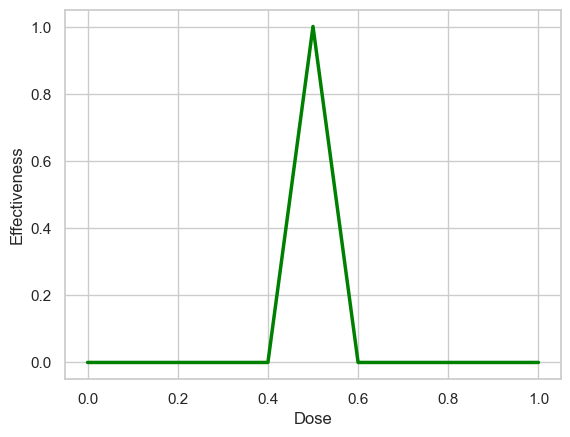

In [ ]:
## run the different doses through the neural network
output_values = model(input_doses)

## set the style for seaborn so that the graph looks cool.
sns.set(style="whitegrid")

## create the graph (you might not see it at this point, but you will after we save it as a PDF).
sns.lineplot(x=input_doses, 
             y=output_values.detach(), ## NOTE: we call detach() because final_bias has a gradient
             color='green', 
             linewidth=2.5)

## now label the y- and x-axes.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')

## lastly, save the graph as a PDF.
# plt.savefig('BasicLightningTrain_optimized.pdf')

In [ ]:
trainer = Trainer(accelerator="mps", devices=1)

NameError: name 'Trainer' is not defined